In [1]:
cuda = "cuda:0"
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim

In [2]:
num_epoch = 10
batch_size = 128
learning_rate = 0.01

In [3]:
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
train_dataset = dsets.MNIST(root='./mydata',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = dsets.MNIST(root='./mydata',train=False,transform=transforms.ToTensor(),download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 93485075.80it/s]


Extracting ./mydata/MNIST/raw/train-images-idx3-ubyte.gz to ./mydata/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103446365.35it/s]


Extracting ./mydata/MNIST/raw/train-labels-idx1-ubyte.gz to ./mydata/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22547971.91it/s]


Extracting ./mydata/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mydata/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1137684.61it/s]


Extracting ./mydata/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mydata/MNIST/raw



In [5]:
len(test_dataset)

10000

In [6]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=len(test_dataset),shuffle=False)

次のように変数を定める
- 入力画像高さ,幅: $I_h$, $I_w$
- フィルタ高さ,幅: $F_h$, $F_w$
- パディング幅: $D$
- ストライド幅: $S$

すると、出力画像の高さ$O_h$と幅$O_w$は次のように表される
$$
O_h = \frac{I_h-F_h+2D}{S}+1\\
O_w = \frac{I_w-F_w+2D}{S}+1
$$


実際に実装する際は少しずつレイヤを組んでいって　next(iter(train_loader)) をto(device)で.size()で実際にサイズを確認しながらが良い

In [7]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16, kernel_size=5, padding=2), # torch.Size([128, 16, 28, 28])
        nn.BatchNorm2d(16),                        # torch.Size([128, 16, 28, 28])
        nn.ReLU(),                                 # torch.Size([128, 16, 28, 28])
        nn.MaxPool2d(2))                           # torch.Size([128, 16, 14, 14])

                                                   # [バッチサイズ, チャネル数, 行数, 列数]
    self.layer2 = nn.Sequential(
        nn.Conv2d(16,32,kernel_size=5,padding=2),  # torch.Size([128, 32, 14, 14])
        nn.BatchNorm2d(32),                        # torch.Size([128, 32, 14, 14])
        nn.ReLU(),                                 # torch.Size([128, 32, 14, 14])
        nn.MaxPool2d(2))                           # torch.Size([128, 32, 7, 7])

    self.fc = nn.Linear(32*7*7, 10)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 32*7*7)
    x = self.fc(x)
    return x

model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [8]:
images, labels = next(iter(train_loader))
images.size()

torch.Size([128, 1, 28, 28])

In [9]:
images = images.to(device)
model(images).size()

torch.Size([128, 10])

In [10]:
model(images)[0].detach()

tensor([ 0.3730,  0.0037,  0.6374, -0.8741, -0.7611, -0.7281, -0.4933, -0.4922,
        -0.3376, -0.1844], device='cuda:0')

In [11]:
torch.argmax(model(images)[0].detach())

tensor(2, device='cuda:0')

In [12]:
predict = model(images).max(1)[1]
labels = labels.to(device)
predict, labels
predict.eq(labels.view_as(predict)).sum().item()

4

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [14]:
def train(train_loader):
  model.train()
  running_loss = 0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader)
  return train_loss

In [15]:
def valid(test_loader):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      predicted = outputs.max(1, keepdim=True)[1]
      correct += predicted.eq(labels.view_as(predicted)).sum().item() # ここで精度を計算
      total += labels.size(0)
  val_loss = running_loss / len(test_loader)
  val_acc = correct / total
  return val_loss, val_acc

In [16]:
record_train_loss = []
record_test_loss = []
record_test_acc = []

for epoch in range(num_epoch):
  train_loss = train(train_loader)
  test_loss, test_acc = valid(test_loader)
  print('Epoch:',epoch,'train_loss:',train_loss,'test_loss:',test_loss,'test_acc:',test_acc)
  record_train_loss.append(train_loss)
  record_test_loss.append(test_loss)
  record_test_acc.append(test_acc)

# save the trained model
np.save('loss_list.npy', np.array(record_train_loss))
np.save('val_loss_list.npy', np.array(record_test_loss))
np.save('val_acc_list.npy', np.array(record_test_acc))
torch.save(model.state_dict(), 'cnn.pkl')

Epoch: 0 train_loss: 0.273692449312538 test_loss: 0.05639129504561424 test_acc: 0.9821
Epoch: 1 train_loss: 0.05175568214230446 test_loss: 0.05477799102663994 test_acc: 0.9824
Epoch: 2 train_loss: 0.0381467139325055 test_loss: 0.04289637506008148 test_acc: 0.9868
Epoch: 3 train_loss: 0.02853502333164215 test_loss: 0.033440761268138885 test_acc: 0.9894
Epoch: 4 train_loss: 0.026725393819383412 test_loss: 0.03195805475115776 test_acc: 0.9904
Epoch: 5 train_loss: 0.021891999196249748 test_loss: 0.03590867668390274 test_acc: 0.9887
Epoch: 6 train_loss: 0.021600486486400568 test_loss: 0.05592169240117073 test_acc: 0.985
Epoch: 7 train_loss: 0.01904615502972563 test_loss: 0.03478219732642174 test_acc: 0.9913
Epoch: 8 train_loss: 0.017126467952473478 test_loss: 0.037910096347332 test_acc: 0.9892
Epoch: 9 train_loss: 0.015806682836966835 test_loss: 0.03871455043554306 test_acc: 0.9891


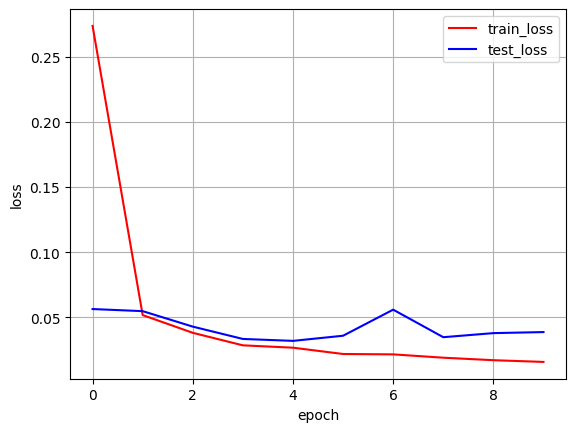

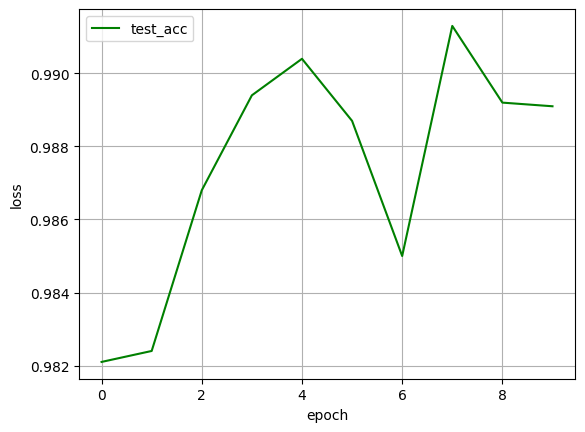

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epoch), record_train_loss, 'r-',label='train_loss')
plt.plot(range(num_epoch), record_test_loss, 'b-',label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epoch), record_test_acc, 'g-',label='test_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()